<h2>Importing libraries</h2>

In [856]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import string
import os
from collections import Counter
from copy import deepcopy
from sklearn import feature_extraction, model_selection,metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

<h2>Loading data</h2>

In [857]:
data = pd.read_csv('/Users/iqra/Documents/machinelearningfromscratch/99-ML-Learning-Projects/svm/data/spam.csv', encoding='latin-1')
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [858]:
data.shape

(5572, 5)

In [859]:
# Renaming columns and dropping unecessary columns
data = data.rename(columns={"v1":'labels',"v2":'sms'})
data.drop(data.columns[[2,3,4]], axis=1, inplace=True)

In [860]:
data.head(5)

,labels,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<h2>Exploring the dataset</h2>

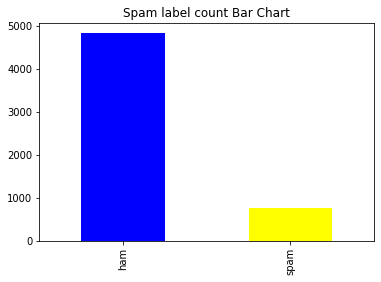

In [861]:
spam_count = pd.value_counts(data['labels'],sort=True)
spam_count.plot(kind='bar',color=['blue','yellow'])
plt.title('Spam label count Bar Chart')
plt.show()

<h2>Feature Engineering</h2>

In [862]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


vectoriser = TfidfVectorizer(analyzer=text_process)
data['smsVect'] = list(vectoriser.fit_transform(data['sms']).toarray())
data.head(2)

,labels,sms,smsVect
0,ham,"Go until jurong point, crazy.. Available only ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,ham,Ok lar... Joking wif u oni...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [863]:
data['labels'] = data['labels'].map({'spam':-1,'ham':1}) # all rows of 'labels' to be one-hot encoded

# put features & outputs in different DataFrames 
y = np.array(data['labels'])  # all rows of 'labels' 
X =  vectoriser.fit_transform(data['sms']).toarray()  # all rows of column 1 and ahead (features)
X, y = shuffle(X,y)

In [864]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30)


In [865]:
y_train

array([ 1,  1,  1, ..., -1,  1, -1])

<h2>Code the SVM algorithm here</h2>

One of the building blocks of every machine learning algorithm, is the loss function. Loss functions measure how closely aligned our model’s current predictions are relative to the set of true labels, and thus we general will find ways to minimize the value of our selected loss. What type of loss function will be use for SVMs? For this tutorial we wil be using the following loss function called hinge loss. Here hinge loss contains C variable, a regularization parameter for SVM. 
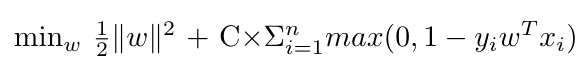


We will be optimizing this loss function above using a technique called stochastic gradient descent. In pseudocode, the general Gradient Descent routine could be described as follows:

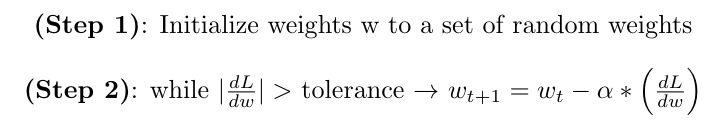

The base gradient descent is defined to update the loss per iteration but as our Hinge Loss function contains a summation over all of the training data points, we will make changes to the base Gradient Descent algorithm above and update the loss in batches of size 1 instead of per iteration. The sub-gradient of hinge loss function is as follows:

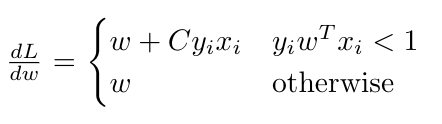

<h3>Define a SVM Class</h3>

We have created an SVM class and encapsulated all the logic of SVM algorithm in this single class called SVM. This class has a constructor, fit and predict methods.  This class will have a constructor and two methods, all of which are outlined below: <br>
__init__: This method essentially constructs the SVM object and we can provide necessary class parameters to it.This ‘constructs’ our SVM object and we will provide it with any class parameters we wish to initialize. <br>
__fit__: This method will be training the model <br>
__predict__: This method will predict labels on test data we haven’t seen by utilizing our model’s fully tweaked weight vector.

In SVM class constructor, we take three components: <br>
__reg_strength__: Our regularization term in the hinge loss optimization <br>
__n_epochs__: The maximum number of iterations we will train our model for in the fit() method <br>
__learning_rate__: The “size” of the steps we will take during each of the training iterations (More on this in a jiffy!)

In [866]:
class SVM:
    def __init__(self, reg_strength, learning_rate, n_epochs):
        ''' Constructor to make our objects. To be defined. '''
        self.reg_strength = reg_strength
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.w = 0
        
        
    
    
    
    def fit(self, X, y_):
        '''fit function for training the model''' 
        n_samples, n_features = X.shape
        self.w = np.random.random((X.shape[1],))
        for iteration in range(self.n_epochs):
            iteration_loss = 0
            iteration_loss += (0.5*np.dot(self.w,self.w))
            iteration_weights = self.w
            for i in range(X.shape[0]):
                y_i = y_[i]
                x_i = X[i]
                condition = y_i*np.dot(self.w, x_i)
                if condition < 1:
                    self.w -= self.learning_rate*(self.w - (self.reg_strength*np.dot(y_i,x_i))) 
                    iteration_loss += self.reg_strength*(1-y_i*np.dot(iteration_weights,x_i))
                    
                    
                else:
                    self.w-=(self.learning_rate*(self.w))
            print("Iteration #" + str(iteration) + " -- iteration loss: " + str(iteration_loss))
                             
        
                
            
        
    
    def predict(self, X):
        '''predict function for testing the model'''
        n_samples, _ = X.shape                                    
        predictions = []
        for i in range(n_samples):
            print(X[i])
            predicted_label = np.dot(self.w,X[i])
            if predicted_label >= 0:
                  predictions.append(1)
            else:
                  predictions.append(-1)
        return predictions
    
  

<h2>Train and test SVM model for spam/ham classification</h2>

In [867]:
C=0.0001
max_iterations=100
learning_rate=0.001
svm_model = SVM(C,learning_rate,max_iterations )
svm_model.fit(X_train, y_train)

Iteration #0 -- iteration loss: 1885.843419189769
Iteration #1 -- iteration loss: 1.1578160640401953
Iteration #2 -- iteration loss: 0.39027867630364627
Iteration #3 -- iteration loss: 0.3899992145388649
Iteration #4 -- iteration loss: 0.38999978332702373
Iteration #5 -- iteration loss: 0.38999979735436174
Iteration #6 -- iteration loss: 0.38999979763878373
Iteration #7 -- iteration loss: 0.3899997976445298
Iteration #8 -- iteration loss: 0.3899997976446463
Iteration #9 -- iteration loss: 0.3899997976446488
Iteration #10 -- iteration loss: 0.38999979764464887
Iteration #11 -- iteration loss: 0.38999979764464887
Iteration #12 -- iteration loss: 0.38999979764464887
Iteration #13 -- iteration loss: 0.38999979764464887
Iteration #14 -- iteration loss: 0.38999979764464887
Iteration #15 -- iteration loss: 0.38999979764464887
Iteration #16 -- iteration loss: 0.38999979764464887
Iteration #17 -- iteration loss: 0.38999979764464887
Iteration #18 -- iteration loss: 0.38999979764464887
Iteration 

In [868]:
Y_test_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, Y_test_pred)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

In [869]:
# test the model and generate classification report
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

          -1       0.96      0.45      0.61       240
           1       0.92      1.00      0.95      1432

    accuracy                           0.92      1672
   macro avg       0.94      0.72      0.78      1672
weighted avg       0.92      0.92      0.91      1672

